# Clustering

## Task 1: Data Preprocessing

As always, we need to load in the dataset in pandas. We immediately concatenate the Summary and text parts to get one combined text. After that, html tags are removed.

In [1]:
import pandas as pd
import re

# Load csv
df = pd.read_csv('../datasets/reviews.csv')
df["full_review"] = df["Summary"].fillna("") + " " + df["Text"].fillna("")

def remove_html(text):
    # Remove everything between <>, replace with space
    return re.sub(r"<.*?>", " ", text)

df["full_review"] = df["full_review"].apply(remove_html)

print("Number of reviews:", len(df))
print("Sample review:\n", df["full_review"].iloc[0])


Number of reviews: 10000
Sample review:
 Crunchy & Good Gluten-Free Sandwich Cookies! Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch.  They're crunchy and true to the texture of the other "real" cookies that aren't gluten-free.  Some might think that the filling makes them a bit too sweet, but for me that just means I've satisfied my sweet tooth sooner!  The chocolate version from Glutino is just as good and has a true "chocolatey" taste - something that isn't there with the other gluten-free brands out there.


We will make the text more usable for the algorithm later on. We remove stop words, lowercase everything and lemmatize the text.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    # Keep only letters
    tokens = [t for t in tokens if t.isalpha()]
    # Optional 1: Removes stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Optional 2: lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["clean_review"] = df["full_review"].apply(preprocess)
print("Cleaned review sample:\n", df["clean_review"].iloc[0])

Cleaned review sample:
 crunchy good sandwich cooky tried couple brand sandwich cooky best bunch crunchy true texture real cooky might think filling make bit sweet mean satisfied sweet tooth sooner chocolate version glutino good true chocolatey taste something brand


Now, 3 types of preprocessing are applied to experiment their performance.

1. Bag of Words

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Leave out words if in less than 5 rewiews, leave out if in more than 95% of reviews
vectorizer = CountVectorizer(max_df=0.70, min_df=50)

X_BoW = vectorizer.fit_transform(df["clean_review"])
print("Bag-of-Words matrix shape:", X_BoW.shape)
#bow_df = pd.DataFrame(X_BoW.toarray(), columns=vectorizer.get_feature_names_out())
#bow_df.head()


Bag-of-Words matrix shape: (10000, 1144)


2. Bert

In [4]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute sentence embeddings from clean reviews
embeddings = model.encode(df["full_review"].tolist(), show_progress_bar=True)

# Convert to numpy array if needed
import numpy as np
X_bert = np.array(embeddings)

print("BERT embedding shape:", X_bert.shape)

/home/nielsvandenbroeck/School/DM/DM_Projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 313/313 [00:08<00:00, 38.16it/s]


BERT embedding shape: (10000, 384)


3. UMAP

In [5]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

# Scale first for UMAP
X_scaled = StandardScaler().fit_transform(X_bert)

# Reduce to 10 dimensions
umap = UMAP(n_components=10)
X_bert_UMAP = umap.fit_transform(X_scaled)
print("BERT reduced embedding shape:", X_bert_UMAP.shape)

/home/nielsvandenbroeck/School/DM/DM_Projects/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


BERT reduced embedding shape: (10000, 10)


## Task 2: Clustering and Evaluation

We introduce 5 clustering algorithms we can experiment with

1. Kmeans clustering

In [6]:
from sklearn.cluster import KMeans

def kmeans_clustering(X, k=10):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    return sil,labels


2. agglomerative clustering

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def agglomerative_clustering(X, k=10, linkage='complete', metric="euclidean"):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric)
    labels = clustering.fit_predict(X)
    sil = silhouette_score(X, labels)
    return sil,labels


3. Gaussian Mixture Models

In [8]:
from sklearn.mixture import GaussianMixture

def gmm_clustering(X, k=10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X)
    sil = silhouette_score(X, labels)
    return sil,labels


4. Spectral clustering

In [9]:
from sklearn.cluster import SpectralClustering

def spectral_clustering(X, k=10, affinity='rbf', n_neighbors=10):
    try:
        sc = SpectralClustering(n_clusters=k, affinity=affinity, random_state=42, assign_labels='kmeans', n_neighbors=n_neighbors)
        labels = sc.fit_predict(X)
        sil = silhouette_score(X, labels)
        return sil,labels
    except Exception as e:
        print(f"Spectral clustering with k={k} failed: {e}")
        return None


5. Dbscan clustering

In [10]:
from sklearn.cluster import DBSCAN

def dbscan_clustering(X, eps_value=0.3, min_samples=5, metric="euclidean"):
    db = DBSCAN(eps=eps_value, min_samples=min_samples, metric=metric)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        sil = silhouette_score(X, labels)
        return sil,labels
    else:
        print(f"[DBSCAN] with eps={eps_value}, insufficient clusters (only 1 or noise).")
        return None


## Compare everything

We can check which words are most present in each cluster using the following code.

In [27]:
import numpy as np

def print_common_words(labels):
    # 1. Retrieve feature names
    terms = vectorizer.get_feature_names_out()

    # 2. Loop over each cluster and compute top terms
    n_clusters = len(np.unique(labels))
    top_n = 10

    for cluster_id in range(n_clusters):
        cluster_docs = np.where(labels == cluster_id)[0]
        cluster_center = X_BoW[cluster_docs].sum(axis=0)

        if hasattr(cluster_center, "toarray"):
            cluster_center = cluster_center.toarray().ravel()
        else:
            cluster_center = np.asarray(cluster_center).ravel()

        top_indices = cluster_center.argsort()[::-1][:top_n]
        top_terms = [terms[i] for i in top_indices]
        scores = [cluster_center[i] for i in top_indices]

        print(f"Cluster {cluster_id} top {top_n} terms:")
        for term, score in zip(top_terms, scores):
            print(f"  {term}: {score:.4f}")

It is possible to show the clusters in a 2 dimensional plot.

In [42]:
import matplotlib.pyplot as plt
import umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap, BoundaryNorm


def plot_clusters(X, labels, title="Agglomerative Clustering (UMAP)", k=4):
    # Reduce to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_2d = reducer.fit_transform(X)

    # Set up discrete colormap
    cmap = ListedColormap(plt.cm.tab10.colors[:k])
    norm = BoundaryNorm(boundaries=np.arange(-0.5, k + 0.5, 1), ncolors=k)

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap, norm=norm, s=30, alpha=0.8)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")

    # Add discrete colorbar
    cbar = plt.colorbar(scatter, ticks=range(k))
    cbar.set_label("Cluster Label")
    cbar.set_ticks(range(k))
    cbar.set_ticklabels([f"Cluster {i}" for i in range(k)])

    plt.tight_layout()
    plt.savefig("clusters.png", dpi=300, bbox_inches='tight')
    plt.show()

Test model takes a clustering algorithm, the embeddings of a preprocessing method and combinations of hyperparameters. All these are parameters are tested and stored in the results list.

In [11]:
from itertools import product

# Contains all results of each run
results = []

def test_model(model_func, X, param_grid):
    best_score = -1
    best_params = {}
    all_combinations = list(product(*param_grid.values()))

    for combo in all_combinations:
        params = dict(zip(param_grid.keys(), combo))
        try:
            score, _ = model_func(X, **params)
            if score is not None and score > best_score:
                best_score = score
                best_params = params
            results.append({
                "data_name": data_name,
                "model_name": model_name,
                "params": params,
                "silhouette": score
            })
            print(f"Params: {params}, silhouette: {score:.4f}" if score else f"Params: {params}, failed")

        # Store error if something failed
        except Exception as e:
            results.append({
                "data_name": data_name,
                "model_name": model_name,
                "params": params,
                "silhouette": None,
                "error": str(e)
            })
            print(f"Params: {params}, error: {e}")

    return best_params, best_score

Now we can simply run all combinations.

In [13]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

X_dict = {
    "UMAP": X_bert_UMAP,
    "BoW": X_BoW,
    "BERT": X_bert,
}

X_param_grid = {
    "BoW": {"normalize_input": False},
    "BERT": {"normalize_input": True},
    "UMAP": {"normalize_input": False}
}

model_functions = {
    "kmeans": kmeans_clustering,
    "agglomerative": agglomerative_clustering,
    "gmm": gmm_clustering,
    "spectral": spectral_clustering,
    "dbscan": dbscan_clustering
}

parameters = {
    "kmeans": {
        "k": [4, 6, 8, 10],
    },
    "gmm": {
        "k": [4, 6, 8, 10],
    },
    "agglomerative": {
        "k": [4, 6, 8, 10],
        "linkage": ["complete", "average", "single"],
        "metric": ["euclidean", "manhattan", "cosine"],
    },
    "spectral": {
        "k": [4, 6, 8, 10],
        "affinity": ["rbf", "nearest_neighbors"],
        #"n_neighbors": [10, 20, 30],
    },
    "dbscan": {
        "eps_value": [0.3, 0.5, 0.7],
        "min_samples": [3, 8],
        "metric": ["euclidean", "manhattan"],
    }
}



for data_name, X in X_dict.items():
    normalize_flag = X_param_grid.get(data_name)["normalize_input"]
    X = normalize(X) if normalize_flag else X
    for model_name, param_grid in parameters.items():
        print(f"\nTesting {model_name} on {data_name}")
        model_func = model_functions[model_name]

        X1 = X.toarray() if (data_name == "BoW" and (model_name == "agglomerative" or model_name == "gmm")) else X

        best_params, best_score = test_model(model_func, X1, param_grid)
        print(f"Best for {model_name} on {data_name}: {best_params} with silhouette={best_score:.4f}")
        print("========================================")

# Save results to DataFrame and CSV
df_results = pd.read_csv("performance_results.csv")
new_df = pd.DataFrame(results)

# Concat if ran in multiple parts (computation limits)
df = pd.concat([df_results, new_df], ignore_index=True)
df_results.to_csv("performance_results.csv", index=False)
print("Results saved to 'performance_results.csv'")



Testing agglomerative on BoW
Params: {'k': 4, 'linkage': 'complete', 'metric': 'euclidean'}, silhouette: 0.7321
Params: {'k': 4, 'linkage': 'complete', 'metric': 'manhattan'}, silhouette: 0.7514
Params: {'k': 4, 'linkage': 'complete', 'metric': 'cosine'}, silhouette: -0.1609
Params: {'k': 4, 'linkage': 'average', 'metric': 'euclidean'}, silhouette: 0.7698
Params: {'k': 4, 'linkage': 'average', 'metric': 'manhattan'}, silhouette: 0.6909
Params: {'k': 4, 'linkage': 'average', 'metric': 'cosine'}, silhouette: -0.1987
Params: {'k': 4, 'linkage': 'single', 'metric': 'euclidean'}, silhouette: 0.7517
Params: {'k': 4, 'linkage': 'single', 'metric': 'manhattan'}, silhouette: 0.6909
Params: {'k': 4, 'linkage': 'single', 'metric': 'cosine'}, silhouette: -0.2188
Params: {'k': 6, 'linkage': 'complete', 'metric': 'euclidean'}, silhouette: 0.7165
Params: {'k': 6, 'linkage': 'complete', 'metric': 'manhattan'}, silhouette: 0.7120
Params: {'k': 6, 'linkage': 'complete', 'metric': 'cosine'}, silhouette:

KeyboardInterrupt: 

A Latex table is created to include in the report.

In [24]:
df_results = pd.read_csv("performance_results.csv")
df_results = df_results.drop(columns=["error"])
df_results = df_results.dropna(subset=["silhouette"])
df_results['silhouette'] = df_results['silhouette'].round(3)
df_results['model_name'] = df_results['model_name'].str.replace('_clustering', '', regex=False)

print(df_results.to_latex())

\begin{tabular}{llllr}
\toprule
 & data_name & model_name & params & silhouette \\
\midrule
0 & UMAP & kmeans & {'k': 4} & 0.372000 \\
1 & UMAP & kmeans & {'k': 6} & 0.434000 \\
2 & UMAP & kmeans & {'k': 8} & 0.455000 \\
3 & UMAP & kmeans & {'k': 10} & 0.405000 \\
4 & UMAP & gmm & {'k': 4} & 0.509000 \\
5 & UMAP & gmm & {'k': 6} & 0.429000 \\
6 & UMAP & gmm & {'k': 8} & 0.465000 \\
7 & UMAP & gmm & {'k': 10} & 0.424000 \\
8 & UMAP & agglomerative & {'k': 4, 'linkage': 'complete', 'metric': 'euclidean'} & 0.352000 \\
9 & UMAP & agglomerative & {'k': 4, 'linkage': 'complete', 'metric': 'manhattan'} & 0.355000 \\
10 & UMAP & agglomerative & {'k': 4, 'linkage': 'complete', 'metric': 'cosine'} & 0.516000 \\
11 & UMAP & agglomerative & {'k': 4, 'linkage': 'average', 'metric': 'euclidean'} & 0.500000 \\
12 & UMAP & agglomerative & {'k': 4, 'linkage': 'average', 'metric': 'manhattan'} & 0.521000 \\
13 & UMAP & agglomerative & {'k': 4, 'linkage': 'average', 'metric': 'cosine'} & 0.523000 \\
14 

## TASK 3: Predict clusters in cluster.csv using best model.

0.5523086
Counter({np.int64(0): 6453, np.int64(1): 1353, np.int64(3): 1293, np.int64(2): 901})
Cluster 0 top 10 terms:
  like: 3072.0000
  taste: 3048.0000
  great: 2923.0000
  good: 2897.0000
  product: 2688.0000
  flavor: 2280.0000
  one: 2089.0000
  love: 1915.0000
  would: 1504.0000
  best: 1294.0000
Cluster 1 top 10 terms:
  dog: 2053.0000
  food: 1873.0000
  cat: 1251.0000
  treat: 1045.0000
  love: 928.0000
  like: 645.0000
  one: 625.0000
  product: 537.0000
  great: 478.0000
  good: 467.0000
Cluster 2 top 10 terms:
  tea: 3010.0000
  taste: 535.0000
  like: 447.0000
  good: 418.0000
  flavor: 401.0000
  great: 357.0000
  green: 307.0000
  one: 300.0000
  bag: 280.0000
  drink: 261.0000
Cluster 3 top 10 terms:
  coffee: 3153.0000
  cup: 751.0000
  like: 720.0000
  good: 666.0000
  taste: 607.0000
  flavor: 595.0000
  great: 529.0000
  one: 492.0000
  love: 360.0000
  strong: 341.0000


/home/nielsvandenbroeck/School/DM/DM_Projects/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/nielsvandenbroeck/School/DM/DM_Projects/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


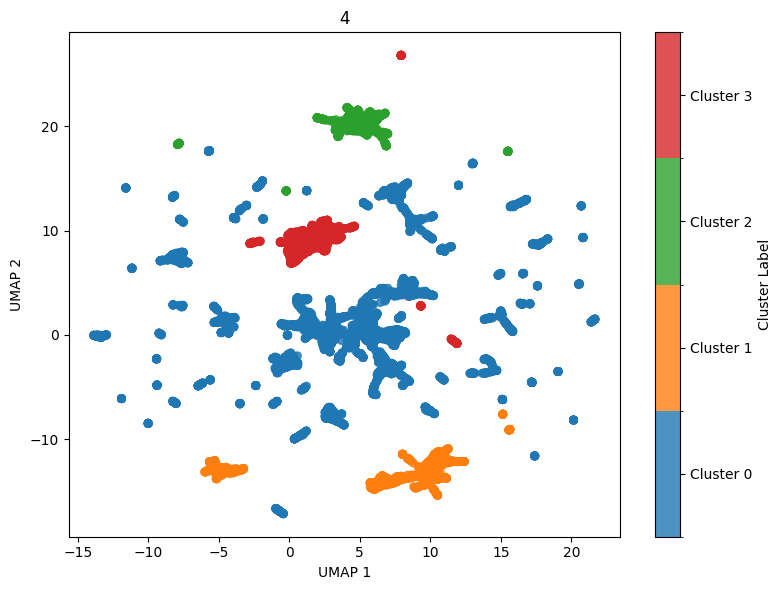

In [43]:
sil, labels = agglomerative_clustering(X_bert_UMAP, k=4, linkage="average", metric="manhattan")
from collections import Counter

label_counts = Counter(labels)
print(sil)
print(label_counts)

print_common_words(labels)
plot_clusters(X_bert_UMAP, labels, 4)


Now simply fill in the labels in cluster.csv

In [30]:
clusterpd = pd.read_csv('../datasets/clusters.csv')
clusterpd["cluster_id"] = labels

clusterpd.to_csv('../datasets/clusters.csv', index=False)
